## Set Environment and import required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os

# IF YOU USE LINUX and there are many GPUs on your machine, SPECIFY THE GPU_ID will make your colleagues happier 
#os.environ['CUDA_VISIBLE_DEVICES'] = "7"

import tensorflow as tf
pd.options.mode.chained_assignment = None # shut the warning up

## Before fitting, let's take a look at the standard psychometric function

Standard form  
$ y = 1 / (1 + exp(n) ) $  

And there is a more generalized form  
$ y = c + (1 / (1 + b*exp(at)) ) $  

### Summary
1. The a will affect how sharp it is, when a = 2, the slope is very large, while a = 0.5 will be smooth
2. b will make the curve shift to right (positive), to left (negative)

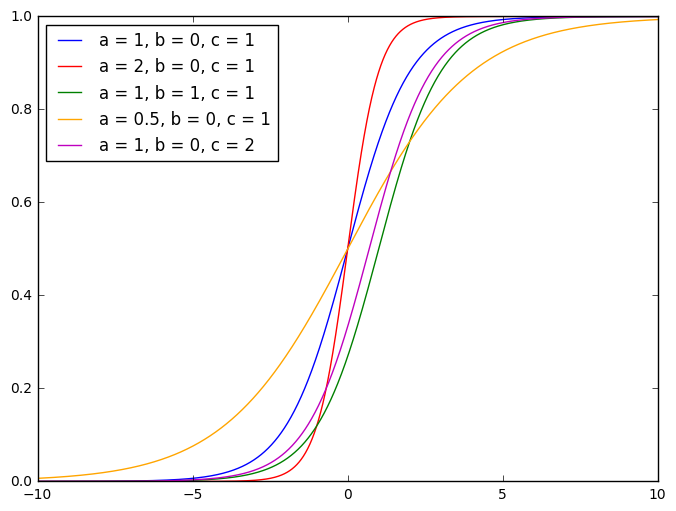

In [2]:
def pseudologit(t, a = 1, b = 0, c = 1):
    y = 1 / (1 + c * math.exp(-(a*t )+b))
    return y

plt.figure(figsize=(8,6))
rn = np.arange(-10,10,0.01)
yn1 = [pseudologit(j) for j in rn]
yn2 = [pseudologit(j, a = 2) for j in rn]
yn3 = [pseudologit(j, a = 1, b = 1) for j in rn]
yn4 = [pseudologit(j, a = 0.5) for j in rn]
yn5 = [pseudologit(j, a = 1, c = 2) for j in rn]

plt.plot(rn, yn1, 'b', label = 'a = 1, b = 0, c = 1')
plt.plot(rn, yn2, 'r', label = 'a = 2, b = 0, c = 1')
plt.plot(rn, yn3, 'g', label = 'a = 1, b = 1, c = 1')
plt.plot(rn, yn4, 'orange', label = 'a = 0.5, b = 0, c = 1')
plt.plot(rn, yn5, 'm', label = 'a = 1, b = 0, c = 2')
plt.legend(loc = 0)
plt.show()

## Use Tensorflow to fit the model
After understanding the general format of the psychometric curve, we start use Tensorflow to fit the data.
#### To use Tensorflow, we use low-level tensor to hand-craft the formula

* "a", "b", and "c" are the parameters that we want to fit (estimated)
* "pred" is the fomula 
* "loss" is how we optimize the curve (minimize the difference between prediction and truth, here we use sum of squared diff)

In [3]:
tf.reset_default_graph()

t = tf.placeholder(dtype=tf.float32)
y = tf.placeholder(dtype=tf.float32)

const = tf.constant(1, dtype=tf.float32)
a = tf.Variable(tf.random_normal([1], mean=-0.5, stddev=0.01)) # this is important, if a > 0, the curve will inverse
b = tf.Variable(tf.random_normal([1]))
c = tf.Variable(tf.random_normal([1]))
pred = c + ( (tf.subtract(const, c)) / (const + tf.exp(tf.multiply(a, tf.subtract(t,b))) ) )
loss = tf.reduce_sum(tf.pow(pred - y, 2))

optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.0001)
update = optimizer.minimize(loss)


## Fit it: read the data and use our pre-defined model to run the fitting process
#### The task of this data is to evalute how a subject perceive and judge the stimuli is a "Short" stimuli of "Long" one (2AFC task)
- Conditions
    1. Stimuli type (1 / 2)
    2. Attention type (1 / 2 / 3)
    3. Session (1 / 2)
- X
    1. Stimuli time, (400, 600, 800, 1000, 1200, 1400, 1600)
- Y
    1. Probability of subject judge it as 1 (long)

Hence, for each subject, there are 12 (conditions) x 7 (stimuli time) data points in our data. In the below paragraph, we'll take 1 subject for example to fit his/her 12 conditions separately.


In [4]:
data_raw = pd.read_csv("raw.csv")
subject_to_fit = 1

data_to_fit = data_raw[data_raw['Subject'] == subject_to_fit]

In [5]:
def tf_fit_psychometric(df, this_subj, this_condition, update_steps = 50000):
    """
    - Description
    df: raw data frame of all subject, condition and results
    this_subj: subjuct id
    this_condition: condition id
    update_steps: how many steps to update the weights
    """
    # Select the Target dataframe
    data_to_fit = df[df['Subject'] == this_subj]
    data_to_fit = data_to_fit[data_to_fit['Condition'] == this_condition]
    
    # make the data into numpy array, and transform them into fed in format
    x_in = data_to_fit.stimuli_time.values
    y_in = data_to_fit.value.values
    
    x_in = np.expand_dims(x_in, axis = -1)
    # Normalize the stimuli from 400 to 1600 seconds to -6 to 6
    x_in = 12 * ((x_in - np.min(x_in)) / (np.max(x_in) - np.min(x_in)) -0.5) 
    y_in = np.expand_dims(y_in, axis = -1)
    y_in = (y_in - np.min(y_in) ) / (np.max(y_in) - np.min(y_in)) 
    
    ### Create TF session and fit it
    # First we create a session
    with tf.Session() as sess:
        # Initalize the variables
        sess.run(tf.global_variables_initializer())
        for step in range(update_steps):
            # Update model
            this_loss, this_pred, _ = sess.run([loss, pred, update], 
                                               feed_dict = {t: x_in,
                                                            y: y_in})
            #print("----")
            # Print the loss every 5000 steps update
            if step % 5000 == 0:
                print("step %i, loss: %.2f" % (step, this_loss))
        # After update done, we fit the full range from 400 to 1600 to get a smooth curve
        x_exam = np.arange(x_in.min(), x_in.max()+1, 1)
        result = sess.run(pred, feed_dict={t: x_exam})
        
    # Generate report data frame
    ori = pd.DataFrame({'Subject': [this_subj], 'Condition': [this_condition]}, dtype=np.int)
    x_exam = ((x_exam / 12) + 0.5 ) * 1200 + 400
    res = pd.DataFrame({'stimuli_time': x_exam, 'tf_fit': result})
    res = pd.concat((ori, res), axis = 1)
    res.Condition[res.Condition.isnull()] = res.Condition.max()
    res.Subject[res.Subject.isnull()] = res.Subject.max()
    # Close the tf session
    sess.close()
    return res

In [6]:
# Fit the first subject, fitst condition
out = tf_fit_psychometric(data_raw, this_subj=1, this_condition=1)

step 0, loss: 1.58
step 5000, loss: 0.13
step 10000, loss: 0.09
step 15000, loss: 0.08
step 20000, loss: 0.07
step 25000, loss: 0.06
step 30000, loss: 0.06
step 35000, loss: 0.06
step 40000, loss: 0.05
step 45000, loss: 0.05


## Plot the result
The blue line is the fitted curve, the red point is the original point.

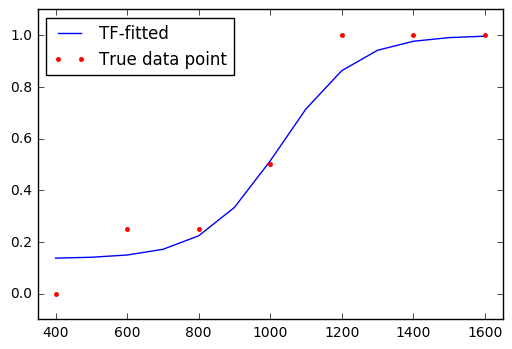

In [7]:
# Xlim and Ylim setting
#plt.plot([400, 1600], [-0.1, 1.1], 'white')
plt.plot(out.stimuli_time, out.tf_fit, 'b', label = 'TF-fitted')
raw_ = data_raw[(data_raw.Subject == 1) & (data_raw.Condition == 1)]
plt.plot(raw_.stimuli_time.values, raw_.value.values, 'r.', label = 'True data point')
plt.legend(loc = 0)
plt.xlim([350, 1650])
plt.ylim([-0.1,1.1])
plt.show()
#out